# Visualizing the autoencoder bottleneck via t-SNE

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 5, Homework (discussed in session 6)

See https://machine-learning-for-physicists.org and the current course website linked there!

This notebook shows how to:
- visualize the bottleneck of convolutional autoencoders using t-SNE

This is built on the basis of the 04_tutorial_CNNtraining notebook on autoencoders.

The networks are 2D convolutional networks, with the same input and output dimensions, and a bottleneck layer in the middle.

You define the network and the type of images that are generated for training – this notebook will help you visualize the training evolution.

### Imports: numpy and matplotlib and keras

In [1]:
# keras: Sequential is the neural-network class, Dense is
# the standard network layer
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, UpSampling2D
from tensorflow.keras import optimizers # to choose more advanced optimizers like 'adam'

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=90 # highres display

# for subplots within subplots:
from matplotlib import gridspec

# for nice inset colorbars: (approach changed from lecture 1 'Visualization' notebook)
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

# for updating display 
# (very simple animation)
from IPython.display import clear_output
from time import sleep

2023-06-13 08:47:33.345658: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The following python code for t-SNE is an original code by the inventor of t-SNE, Laurens van der Maaten. It is available on his website https://lvdmaaten.github.io/tsne/ . 

It is stated on that website: "*You are free to use, modify, or redistribute this software in any way you want, but only for non-commercial purposes. The use of the software is at your own risk; the authors are not responsible for any damage as a result from errors in the software.*"

In [2]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

# note by FM: For this notebook, the MNIST example was dropped

import numpy as np

def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        if i % 500 == 0:
            print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P


def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y


def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0, 
         do_animation=False, animation_skip_steps=10, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
        
        Added by F. Marquardt: do_animation==True will give you a graphical animation of
        the progress, use animation_skip_steps to control how often this will
        be plotted; max_iter controls the total number of gradient descent steps
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims).real
    (n, d) = X.shape
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.									# early exaggeration
    P = np.maximum(P, 1e-12)

    if do_animation: # added by FM
        costs=np.zeros(max_iter) # to store the cost values
        
    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        if not do_animation: # added by FM: do not print if we are animating!
            # Compute current value of cost function
            if (iter + 1) % 10 == 0:
                C = np.sum(P * np.log(P / Q))
                print("Iteration %d: error is %f" % (iter + 1, C), end="           \r") # modified to overwrite line

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.
            
        if do_animation:  # added by FM
            C = np.sum(P * np.log(P / Q)) # compute for every step, to store it in 'costs'
            costs[iter]=C
            if iter % animation_skip_steps==0:
                clear_output(wait=True)
                fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                ax[0].plot(costs)
                ax[1].scatter(Y[:,0],Y[:,1],color="orange")
                plt.show()

    # Return solution
    return Y


# if __name__ == "__main__":
#     print("Run Y = tsne.tsne(X, no_dims, perplexity) to perform t-SNE on your dataset.")
#     print("Running example on 2,500 MNIST digits...")
#     X = np.loadtxt("mnist2500_X.txt")
#     labels = np.loadtxt("mnist2500_labels.txt")
#     Y = tsne(X, 2, 50, 20.0)
#     pylab.scatter(Y[:, 0], Y[:, 1], 20, labels)
#     pylab.show()



### Functions

In [3]:
# visualization routines:

def visualize_CNN_training(network,
                               image_generator, resolution,
                    steps=100, batchsize=10,
                              visualize_nsteps=1, plot_img_pixels=3,
                          plot_img_cols=10,
                          plot_img_rows=5,
                          show_intermediate_layers=True):
    """
    Visualize the training of a (2D) convolutional neural network autoencoder.
    
    network is the network that you have defined using keras.
    
    'resolution' (called M below) is the image resolution in pixels
    
    image_generator is the name of a function that
    is called like
        image_generator(batchsize,x,y)
    and which has to return an array of shape
        [batchsize,M,M]
    that contains randomly generated MxM images (e.g. randomly
    placed circles or whatever you want to consider). The
    MxM arrays x and y are already filled with coordinates between -1 and 1.
    
    An example that returns images of randomly placed circles:
    
    def my_generator(batchsize,x,y):
        R=np.random.uniform(size=batchsize)
        x0=np.random.uniform(size=batchsize,low=-1,high=1)
        y0=np.random.uniform(size=batchsize,low=-1,high=1)
        return( 1.0*((x[None,:,:]-x0[:,None,None])**2 + (y[None,:,:]-y0[:,None,None])**2 < R[:,None,None]**2) )

   
    steps is the number of training steps
    
    batchsize is the number of samples per training step
            
    visualize_n_steps>1 means skip some steps before
    visualizing again (can speed up things)
    
    show_intermediate_layers==True means show the intermediate activations.
    Otherwise show the weights!
    
    These are always shown in the upper left corner, as a tiled image,
    whose properties are determined by:
        plot_img_pixels: the resolution for each of the image tiles
        plot_img_cols  : the number of columns of images
        plot_img_rows  : the number of rows of images
    Images (activations or weights) that are larger will be cut off.
    If there are more images than fit, the rest will be left out.
    The lowest layer starts in the bottom left. For activations, for
    each layer one runs through all the channels, and then the images
    for the next layer will start. Likewise for weights.
    """
    global y_target # allow access to target from outside
    
    M=resolution
        
    vals=np.linspace(-1,1,M)
    x,y=np.meshgrid(vals,vals)
    
    y_test=np.zeros([1,M,M,1])
    y_test[:,:,:,0]=image_generator(1,x,y)
    
    y_in=np.zeros([batchsize,M,M,1])

    costs=np.zeros(steps)
    extractor=get_layer_activation_extractor(network)
    
    for j in range(steps):
        # produce samples:
        y_in[:,:,:,0]=image_generator(batchsize,x,y)
        y_target=np.copy(y_in) # autoencoder wants to reproduce its input!
        
        # do one training step on this batch of samples:
        costs[j]=network.train_on_batch(y_in,y_target)
        
        # now visualize the updated network:
        if j%visualize_nsteps==0:
            clear_output(wait=True) # for animation
            if j>10:
                cost_max=np.average(costs[0:j])*1.5
            else:
                cost_max=costs[0]
            
            # nice layout (needs matplotlib v3)
            fig=plt.figure(constrained_layout=True,figsize=(8,4))
            gs=fig.add_gridspec(ncols=8,nrows=4)
            filter_plot=fig.add_subplot(gs[0:3,0:4])
            cost_plot=fig.add_subplot(gs[3,0:4])
            test_in_plot=fig.add_subplot(gs[0:2,4:6])
            test_out_plot=fig.add_subplot(gs[0:2,6:8])

            cost_plot.plot(costs)
            cost_plot.set_ylim([0,cost_max])
            
            # test the network on a fixed test image!
            y_test_out=network.predict_on_batch(y_test)
            test_in_plot.imshow(y_test[0,:,:,0],origin='lower')
            test_out_plot.imshow(y_test_out[0,:,:,0],origin='lower')
            test_in_plot.axis('off')
            test_out_plot.axis('off')
            
            if show_intermediate_layers:
                features=extractor(y_test)
                n1=0; n2=0
                max_n1=plot_img_rows
                max_n2=plot_img_cols
                pix=plot_img_pixels
                img=np.full([(pix+1)*max_n1,(pix+1)*max_n2],1.0)
                for feature in features:
                    for m in range(feature.shape[-1]):
                        w=feature[0,:,:,m]
                        ws=np.shape(w)
                        if n1<max_n1 and n2<max_n2:
                            W=np.zeros([pix,pix])
                            if ws[0]<pix:
                                W[0:ws[0],0:ws[0]]=w[:,:]
                            else:
                                W[:,:]=w[0:pix,0:pix]                            
                            img[n1*(pix+1):(n1+1)*(pix+1)-1,n2*(pix+1):(n2+1)*(pix+1)-1]=W
                            n2+=1
                            if n2>=max_n2:
                                n2=0
                                n1+=1                
            else: # rather, we want the weights! (filters)
                n1=0; n2=0
                max_n1=plot_img_rows
                max_n2=plot_img_cols
                pix=plot_img_pixels
                img=np.zeros([(pix+1)*max_n1,(pix+1)*max_n2])
                for ly in network.layers:
                    w=ly.get_weights()
                    if w!=[]:
                        w=w[0]
                        ws=np.shape(w)
                        for k1 in range(ws[2]):
                            for k2 in range(ws[3]):
                                if n1<max_n1 and n2<max_n2:
                                    W=np.zeros([pix,pix])
                                    if ws[0]<pix:
                                        W[0:ws[0],0:ws[0]]=w[:,:,k1,k2]
                                    else:
                                        W[:,:]=w[0:pix,0:pix,k1,k2]                            
                                    img[n1*(pix+1):(n1+1)*(pix+1)-1,n2*(pix+1):(n2+1)*(pix+1)-1]=W
                                    n2+=1
                                    if n2>=max_n2:
                                        n2=0
                                        n1+=1
            filter_plot.imshow(img,origin='lower')
            filter_plot.axis('off')
            plt.show()
    print("Final cost value (averaged over last 50 batches): ", np.average(costs[-50:]))


def print_layers(network, y_in):
    """
    Call this on some test images y_in, to get a print-out of
    the layer sizes. Shapes shown are (batchsize,pixels,pixels,channels).
    After a call to the visualization routine, y_target will contain
    the last set of training images, so you could feed those in here.
    """
    layer_features=get_layer_activations(network,y_in)
    for idx,feature in enumerate(layer_features):
        s=np.shape(feature)
        print("Layer "+str(idx)+": "+str(s[1]*s[2]*s[3])+" neurons / ", s)

def get_layer_activation_extractor(network):
    return(Model(inputs=network.inputs,
                            outputs=[layer.output for layer in network.layers]))

def get_layer_activations(network, y_in):
    """
    Call this on some test images y_in, to get the intermediate 
    layer neuron values. These are returned in a list, with one
    entry for each layer (the entries are arrays).
    """
    extractor=get_layer_activation_extractor(network)
    layer_features = extractor(y_in)
    return(layer_features)


## Example: Reproducing both randomly placed squares AND rotated squares with the same autoencoder


In [4]:
def my_generator_squares_rotated(batchsize,x,y):
    global IsRotated
    
    R=np.random.uniform(size=batchsize,low=0.3,high=0.7)
    x0=np.random.uniform(size=batchsize,low=-0.4,high=0.4)
    y0=np.random.uniform(size=batchsize,low=-0.4,high=0.4)
    # make half of them rotated squares
    IsRotated=1.0*(np.random.uniform(size=batchsize)<0.5)
    dx=x[None,:,:]-x0[:,None,None]
    dy=y[None,:,:]-y0[:,None,None]
    RotatedSquares=1.0*(np.abs(dx+dy)/np.sqrt(2)<R[:,None,None])*(np.abs(dx-dy)/np.sqrt(2)< R[:,None,None])
    Squares=1.0*(np.abs(dx)<R[:,None,None])*(np.abs(dy)< R[:,None,None])
    return( IsRotated[:,None,None]*RotatedSquares+(1-IsRotated[:,None,None])*Squares )



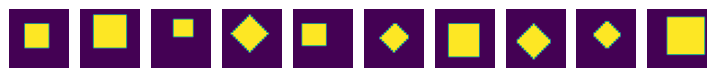

In [5]:
# make a few test input images
batchsize=10
M=27
vals=np.linspace(-1,1,M)
x,y=np.meshgrid(vals,vals)
test_input=my_generator_squares_rotated(batchsize,x,y)

fig,ax=plt.subplots(ncols=batchsize,nrows=1,figsize=(batchsize,1))
for n in range(batchsize):
    ax[n].imshow(test_input[n,:,:],origin='lower')
    ax[n].axis('off')
plt.show()

In [6]:

Net=Sequential()
Net.add(Conv2D(20,5,input_shape=(None,None,1),
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
Net.add(Conv2D(20,5,
               activation="relu",padding='same'))
Net.add(AveragePooling2D(pool_size=(3,3),padding='same')) # down
Net.add(Conv2D(1,3,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(3,3))) # up
Net.add(Conv2D(20,5,
               activation="relu",padding='same'))
Net.add(UpSampling2D(size=(3,3))) # up
Net.add(Conv2D(20,5,
               activation="relu",padding='same'))
Net.add(Conv2D(1,3,activation="linear",padding='same'))
Net.compile(loss='mean_squared_error',
              optimizer='adam')

2023-06-13 08:47:57.528392: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


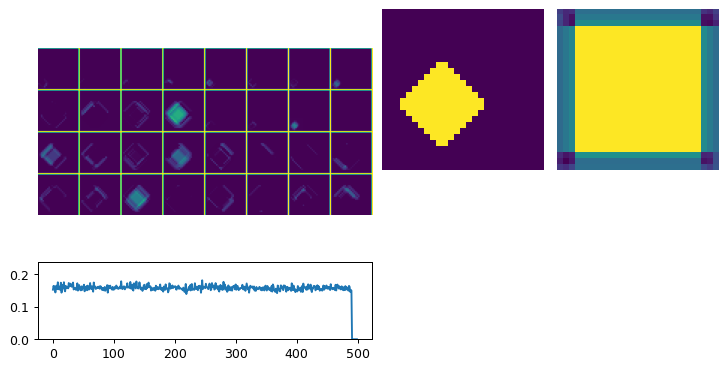

Final cost value (averaged over last 50 batches):  0.1572299474477768


In [8]:
visualize_CNN_training(Net, my_generator_squares_rotated, 9*3,
                    steps=500, batchsize=30,
                              visualize_nsteps=10,
                      plot_img_cols=8, plot_img_rows=4,
                      plot_img_pixels=27)

In [9]:
print_layers(Net,y_target) # find out layer sizes for these training images!
# y_target is a global variable that is initialized by the
# training visualization routine, and it contains the last few training images.

Layer 0: 14580 neurons /  (30, 27, 27, 20)
Layer 1: 1620 neurons /  (30, 9, 9, 20)
Layer 2: 1620 neurons /  (30, 9, 9, 20)
Layer 3: 180 neurons /  (30, 3, 3, 20)
Layer 4: 9 neurons /  (30, 3, 3, 1)
Layer 5: 81 neurons /  (30, 9, 9, 1)
Layer 6: 1620 neurons /  (30, 9, 9, 20)
Layer 7: 14580 neurons /  (30, 27, 27, 20)
Layer 8: 14580 neurons /  (30, 27, 27, 20)
Layer 9: 729 neurons /  (30, 27, 27, 1)


#### Create a few test input images

In [10]:
# make a few test input images
batchsize=4000 # 4000 will take a long time for tSNE, but gives nicer separation of the two categories!
M=27
vals=np.linspace(-1,1,M)
x,y=np.meshgrid(vals,vals)
test_input=my_generator_squares_rotated(batchsize,x,y)

layer_activations=get_layer_activations(Net,test_input)


In [11]:
len(layer_activations) # should be number of layers

10

In [13]:
np.shape(layer_activations[4]) # should be [batchsize,npixels,npixels,channels]

TensorShape([4000, 3, 3, 1])

#### Make a scatterplot of two bottleneck neuron values

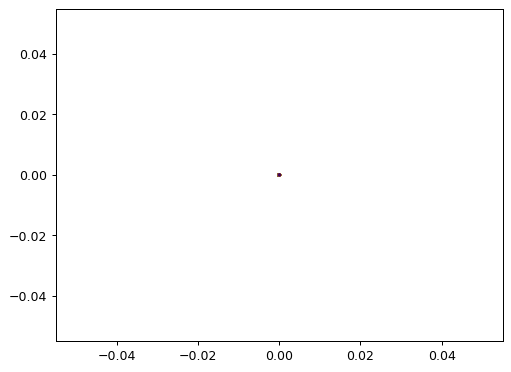

In [16]:
which=[[2,1],[1,2]]

bottleneck=4
activation=np.zeros([2,batchsize])
for n in range(2): # extract TWO of the neuron values (which ones: determined by 'which')
    activation[n,:]=layer_activations[bottleneck][:,which[n][0],which[n][1],0]

plt.scatter(activation[0,:],activation[1,:],s=4,c=IsRotated)
plt.show()


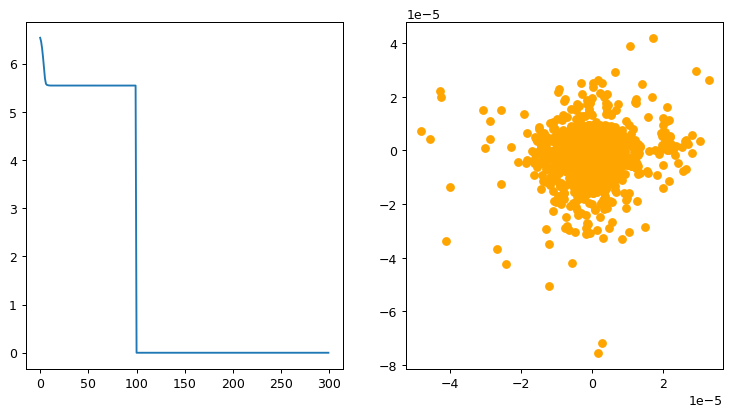

KeyboardInterrupt: 

In [17]:
# now apply t-SNE to reduce to two dimensions in a smart way!

shape=np.shape(layer_activations[bottleneck])
 # all neuron activations in the bottleneck layer:
X=np.reshape(layer_activations[bottleneck][:,:,:,0],[batchsize,shape[1]*shape[2]])
Y=tsne(X, no_dims=2, initial_dims=9, perplexity=20.0, 
       do_animation=True, animation_skip_steps=10, max_iter=300)

# plot the points according to the t-SNE projection into 2D space
# color them according to the cluster they belong to!
plt.figure(figsize=(8,8))
plt.scatter(Y[:,0],Y[:,1],s=4,c=IsRotated)
plt.show()

Comment: One clearly sees that the two types of objects get sorted into different parts of the tSNE map. Nevertheless, if they were not colored, you wouldn't know there are two categories.